In [14]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [24]:
!unzip "/content/drive/MyDrive/fp-dataset-artifacts-main (1).zip" -d "/content/drive/MyDrive/"



Archive:  /content/drive/MyDrive/fp-dataset-artifacts-main (1).zip
e7e04aa772efddd8e4b95688d3b05a981a7e0960
   creating: /content/drive/MyDrive/fp-dataset-artifacts-main/
 extracting: /content/drive/MyDrive/fp-dataset-artifacts-main/.gitignore  
  inflating: /content/drive/MyDrive/fp-dataset-artifacts-main/README.md  
  inflating: /content/drive/MyDrive/fp-dataset-artifacts-main/helpers.py  
  inflating: /content/drive/MyDrive/fp-dataset-artifacts-main/requirements.txt  
  inflating: /content/drive/MyDrive/fp-dataset-artifacts-main/run.py  


In [15]:
%cd "/content/drive/MyDrive/fp-dataset-artifacts-main"


/content/drive/MyDrive/fp-dataset-artifacts-main


In [17]:
!pip install accelerate datasets torch tqdm evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


In [11]:
!python3 run.py --do_train --task nli --dataset snli --output_dir ./trained_model/


python3: can't open file '/content/run.py': [Errno 2] No such file or directory


In [18]:
!python3 run.py --do_eval --task nli --dataset snli --model ./trained_model/ --output_dir ./eval_output/

2025-11-29 02:51:32.419900: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-29 02:51:32.439720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764384692.463592    2722 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764384692.473256    2722 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764384692.500134    2722 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [19]:

!pip install transformers datasets scikit-learn seaborn -q



In [20]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [21]:
snli = load_dataset("snli")
test_set = snli['test']

In [31]:
test_set = test_set.filter(lambda x: x['label'] != -1)

Filter:   0%|          | 0/9824 [00:00<?, ? examples/s]

In [34]:
print("Total examples after filtering out invalid:", len(test_set))

Total examples after filtering out invalid: 9824


In [22]:
import re
negation_words = [
    # Adverbs/particles
    "not", "never", "no", "none", "nothing",

    # Negative auxiliary verbs (full forms)
    "is not", "are not", "was not", "were not",
    "does not", "do not", "did not",
    "has not", "have not", "had not",
    "cannot", "will not", "would not",
    "should not", "could not",

    # Negative auxiliary verbs (contractions)
    "isn't", "aren't", "wasn't", "weren't",
    "doesn't", "don't", "didn't",
    "hasn't", "haven't", "hadn't",
    "can't", "won't", "wouldn't", "shouldn't", "couldn't",

    # Negative pronouns
    "nobody", "no one", "neither", "nowhere", "none of"
]


In [23]:
import re

def has_negation(hypothesis):
    hyp = hypothesis.lower()
    # check each negation word as a whole word
    for neg in negation_words:
        # \b ensures it matches only as a whole word
        if re.search(rf'\b{re.escape(neg)}\b', hyp):
            return True
    return False



In [37]:
negated_subset = test_set.filter(lambda x: has_negation(x['hypothesis']))
print(f"Total naturally negated hypotheses: {len(negated_subset)}")

non_negated_subset = test_set.filter(lambda x: not has_negation(x['hypothesis']))
print(f"Total non-negated hypotheses: {len(non_negated_subset)}")

Total naturally negated hypotheses: 205
Total non-negated hypotheses: 9619


In [25]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_path = "./trained_model/"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print("num_labels:", model.config.num_labels)

num_labels: 3


In [26]:
def predict_label(premise, hypothesis):
    inputs = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.argmax(logits, dim=-1).item()

Accuracy on naturally negated hypotheses: 0.9024390243902439
Confusion matrix (rows=true, cols=pred) for negated subset:
 [[ 21   1   4]
 [  2  28   5]
 [  0   8 136]]


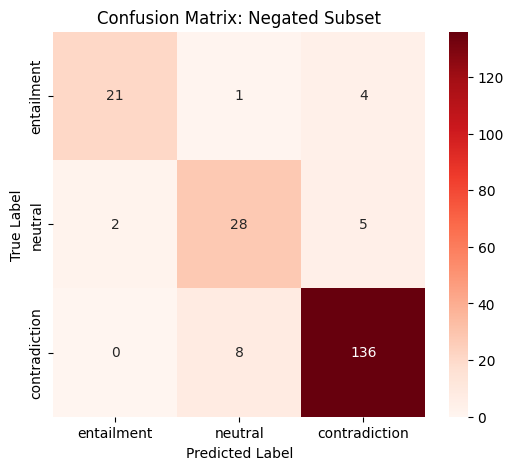

Total misclassified (negated subset): 20

Premise:  Many people standing outside of a place talking to each other in front of a building that has a sign that says "HI-POINTE."
Hypothesis:  The group of people aren't inide of the building.
True label:  0
Predicted label:  2
--------------------------------------------------
Premise:  a boy in a red hooded top is smiling whilst looking away from his reflection.
Hypothesis:  The boy doesn't want to see his reflection.
True label:  1
Predicted label:  0
--------------------------------------------------
Premise:  A very dirty race car doing a burnout on some dirt.
Hypothesis:  A car that has no tires.
True label:  2
Predicted label:  1
--------------------------------------------------
Premise:  An Ambulance is passing a man wearing a bandanna and girl.
Hypothesis:  The ambulance isn't stopped by heavy traffic
True label:  0
Predicted label:  1
--------------------------------------------------
Premise:  A fighter jet plane is landed outsi

In [39]:
# =========================
# 5. Evaluate on NEGATED subset
# =========================
import numpy as np

y_true_neg = []
y_pred_neg = []

for row in negated_subset:
    y_true_neg.append(row["label"])
    y_pred_neg.append(predict_label(row["premise"], row["hypothesis"]))

y_true_neg = np.array(y_true_neg)
y_pred_neg = np.array(y_pred_neg)

acc_negated = accuracy_score(y_true_neg, y_pred_neg)
cm_negated = confusion_matrix(y_true_neg, y_pred_neg, labels=[0, 1, 2])

print("Accuracy on naturally negated hypotheses:", acc_negated)
print("Confusion matrix (rows=true, cols=pred) for negated subset:\n", cm_negated)

labels = ["entailment", "neutral", "contradiction"]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_negated,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Negated Subset")
plt.show()

# Show first 10 misclassified examples
misclassified_neg = []
for i, row in enumerate(negated_subset):
    if y_true_neg[i] != y_pred_neg[i]:
        misclassified_neg.append({
            "premise": row["premise"],
            "hypothesis": row["hypothesis"],
            "true_label": int(y_true_neg[i]),
            "pred_label": int(y_pred_neg[i])
        })

print(f"Total misclassified (negated subset): {len(misclassified_neg)}\n")

for example in misclassified_neg[:10]:
    print("Premise: ", example["premise"])
    print("Hypothesis: ", example["hypothesis"])
    print("True label: ", example["true_label"])
    print("Predicted label: ", example["pred_label"])
    print("-" * 50)


Accuracy on non-negated hypotheses: 0.8874103337145234
Confusion matrix (rows=true, cols=pred) for non-negated subset:
 [[3014  268   60]
 [ 247 2711  226]
 [  73  209 2811]]


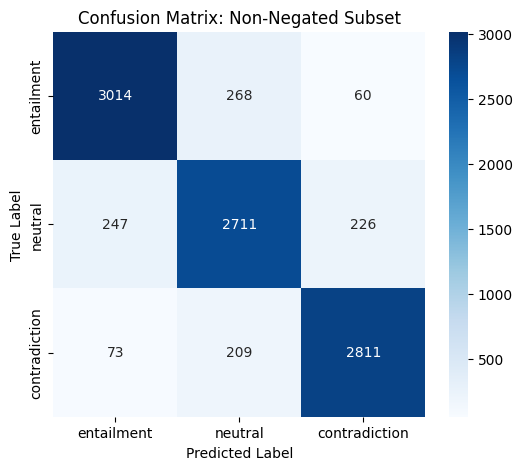

In [41]:
# =========================
# 6. Evaluate on NON-NEGATED subset (comparison)
# =========================
y_true_non = []
y_pred_non = []

for row in non_negated_subset:
    y_true_non.append(row["label"])
    y_pred_non.append(predict_label(row["premise"], row["hypothesis"]))

y_true_non = np.array(y_true_non)
y_pred_non = np.array(y_pred_non)

acc_non_negated = accuracy_score(y_true_non, y_pred_non)
cm_non_negated = confusion_matrix(y_true_non, y_pred_non, labels=[0, 1, 2])

print("Accuracy on non-negated hypotheses:", acc_non_negated)
print("Confusion matrix (rows=true, cols=pred) for non-negated subset:\n", cm_non_negated)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_non_negated,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Non-Negated Subset")
plt.show()

In [42]:
# =========================
# 7. Breakdown: how often predicted as CONTRADICTION
# =========================
def breakdown_to_contradiction(y_true, y_pred, name: str):
    print(f"\n{name}: how often predicted as CONTRADICTION (label=2)")
    for true_lbl, label_name in zip([0, 1, 2], ["entailment", "neutral", "contradiction"]):
        mask = (y_true == true_lbl)
        if mask.sum() == 0:
            print(f"No examples with true label = {label_name}")
            continue
        total = mask.sum()
        pred_contra = ((y_pred == 2) & mask).sum()
        print(
            f"True {label_name}: {pred_contra}/{total} "
            f"({pred_contra / total:.2%}) predicted as contradiction"
        )

breakdown_to_contradiction(y_true_neg, y_pred_neg, "Negated subset")
breakdown_to_contradiction(y_true_non, y_pred_non, "Non-negated subset")



Negated subset: how often predicted as CONTRADICTION (label=2)
True entailment: 4/26 (15.38%) predicted as contradiction
True neutral: 5/35 (14.29%) predicted as contradiction
True contradiction: 136/144 (94.44%) predicted as contradiction

Non-negated subset: how often predicted as CONTRADICTION (label=2)
True entailment: 60/3342 (1.80%) predicted as contradiction
True neutral: 226/3184 (7.10%) predicted as contradiction
True contradiction: 2811/3093 (90.88%) predicted as contradiction


In [49]:
# =========================
# 8. (Optional) Minimal-pair probe for negation
# =========================
label_map = {0: "entailment", 1: "neutral", 2: "contradiction"}

def show_minimal_pair(premise, hyp1, hyp2):
    l1 = predict_label(premise, hyp1)
    l2 = predict_label(premise, hyp2)
    print("Premise:", premise)
    print("Hyp 1:", hyp1, "->", label_map[l1])
    print("Hyp 2:", hyp2, "->", label_map[l2])
    print("-" * 50)

show_minimal_pair(
    "A woman is laughing.",
    "The woman is laughing.",
    "The woman is not laughing."
)

show_minimal_pair(
    "A man is riding a bike.",
    "The man is riding a bike.",
    "The man is not sleeping."
)

Premise: A woman is laughing.
Hyp 1: The woman is laughing. -> entailment
Hyp 2: The woman is not laughing. -> contradiction
--------------------------------------------------
Premise: A man is riding a bike.
Hyp 1: The man is riding a bike. -> entailment
Hyp 2: The man is not sleeping. -> entailment
--------------------------------------------------
